In [38]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

%matplotlib inline

In [39]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


In [51]:
forex = yf.download('EURUSD=X', period='5d', interval='1m')
forex = forex[['Close']]
forex.index = pd.to_datetime(forex.index)
forex.tail()

[*********************100%***********************]  1 of 1 completed


,Close
Datetime,
2023-03-10 13:26:00+00:00,1.059210
2023-03-10 13:27:00+00:00,1.059322
2023-03-10 13:28:00+00:00,1.059322
2023-03-10 13:29:00+00:00,1.059434
2023-03-10 13:30:00+00:00,1.061684


In [52]:
df = forex.copy()
df['Time'] = np.arange(len(forex.index))
df.head()

,Close,Time
Datetime,,
2023-03-06 00:00:00+00:00,1.062812,0
2023-03-06 00:01:00+00:00,1.062925,1
2023-03-06 00:02:00+00:00,1.062925,2
2023-03-06 00:03:00+00:00,1.062925,3
2023-03-06 00:04:00+00:00,1.063151,4


In [53]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']] # features
y = df.loc[:, 'Close'] # target

# train the model
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Text(0.5, 1.0, 'Time Plot of Forex')

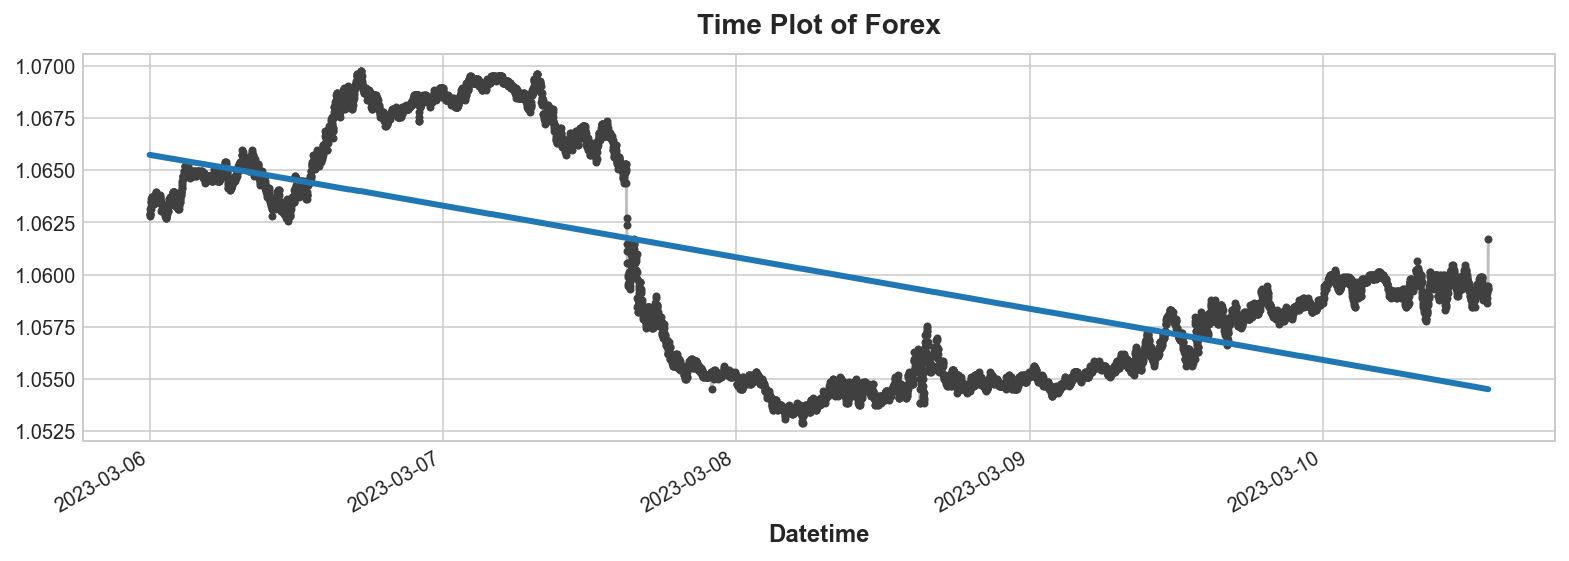

In [54]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Forex')

## Lag Feature

In [55]:
df['Lag_1'] = df['Close'].shift(1)
df.head()

,Close,Time,Lag_1
Datetime,,,
2023-03-06 00:00:00+00:00,1.062812,0,NaN
2023-03-06 00:01:00+00:00,1.062925,1,1.062812
2023-03-06 00:02:00+00:00,1.062925,2,1.062925
2023-03-06 00:03:00+00:00,1.062925,3,1.062925
2023-03-06 00:04:00+00:00,1.063151,4,1.062925


In [56]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)

y = df.loc[:, 'Close']
y, X = y.align(X, join='inner')

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Text(0.5, 1.0, 'Lag Plot of Forex')

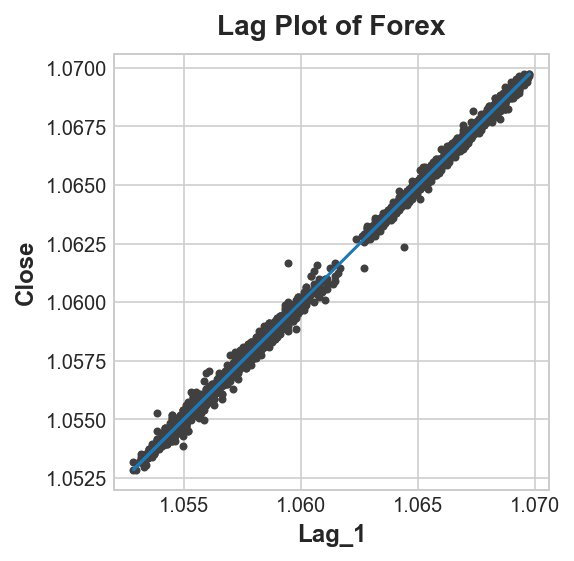

In [57]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('Close')
ax.set_xlabel('Lag_1')
ax.set_title("Lag Plot of Forex")

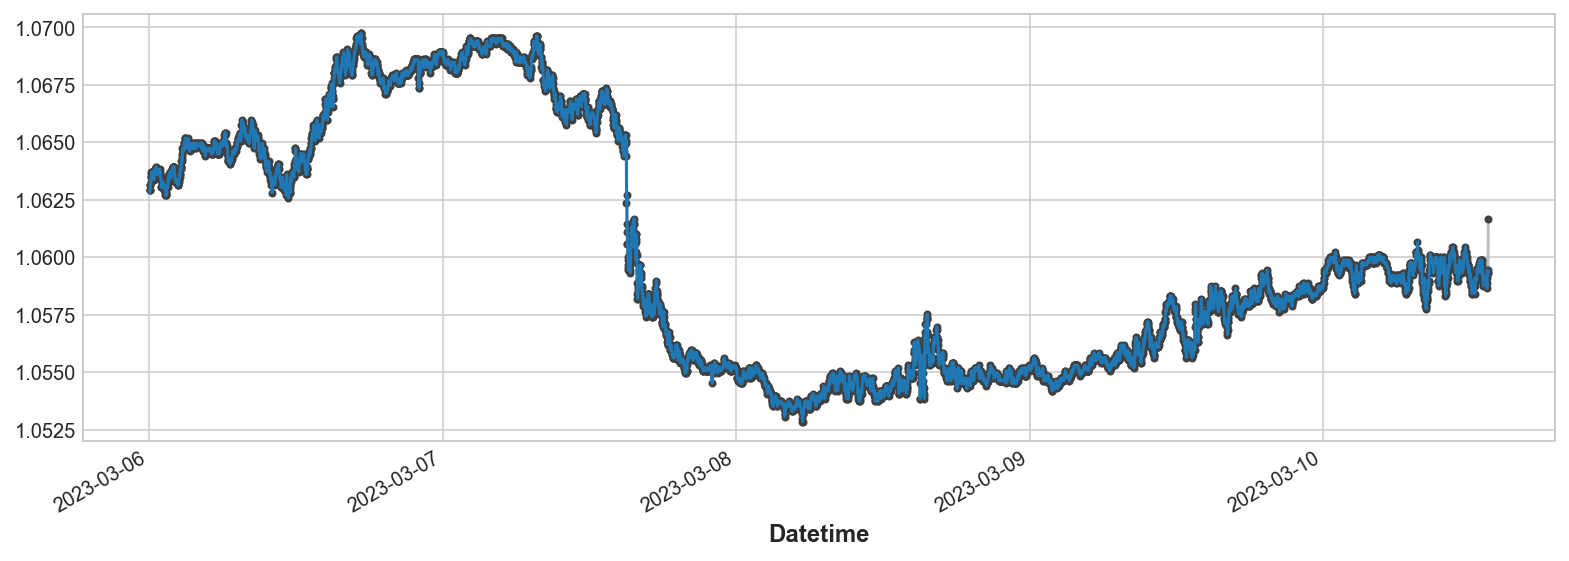

In [58]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

## Trend

<AxesSubplot:title={'center':'Forex 5 day ma'}, xlabel='Datetime'>

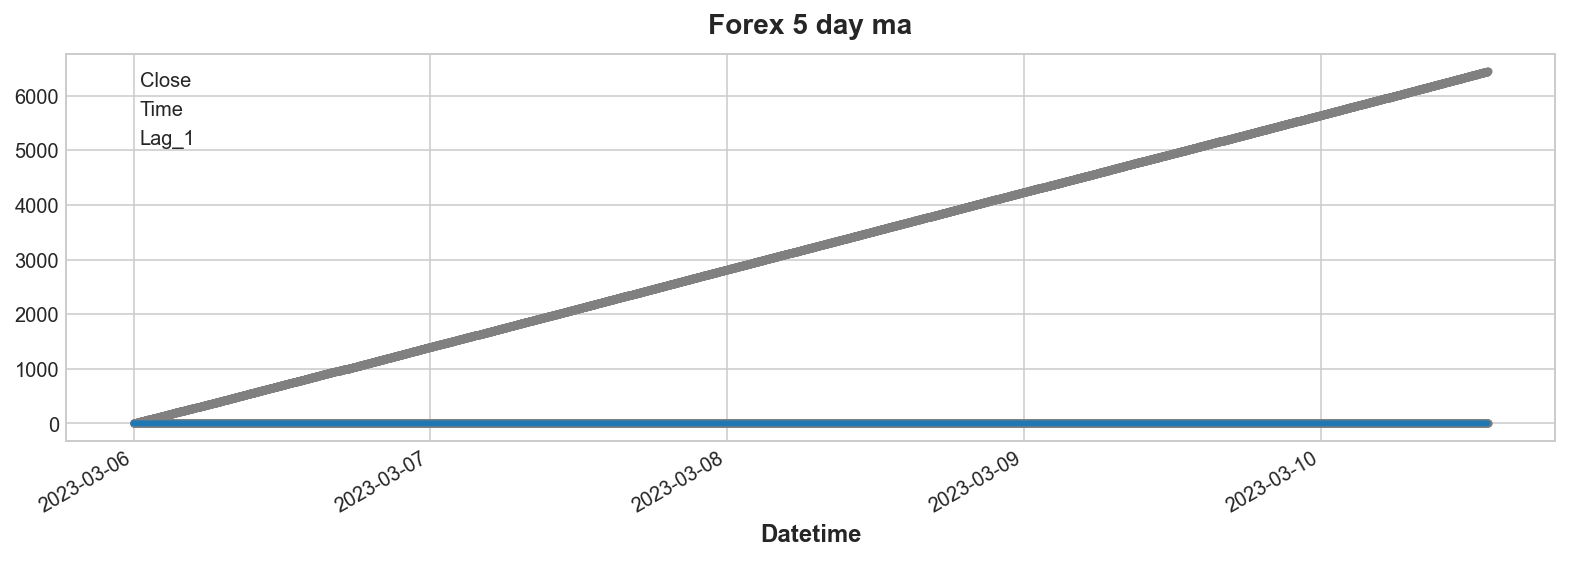

In [65]:
moving_average = forex.rolling(
    window=5, 
    center=True,
    min_periods=3,
).mean()

ax = df.plot(style=".", color='0.5')
moving_average.plot(
    ax=ax, 
    linewidth=3, 
    title='Forex 5 day ma',
    legend=False,
)


In [60]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=forex.index,
    constant=True,
    order=1,
    drop=True,
)

X = dp.in_sample()

X.head()

,const,trend
Datetime,,
2023-03-06 00:00:00+00:00,1.0,1.0
2023-03-06 00:01:00+00:00,1.0,2.0
2023-03-06 00:02:00+00:00,1.0,3.0
2023-03-06 00:03:00+00:00,1.0,4.0
2023-03-06 00:04:00+00:00,1.0,5.0


A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.

In [61]:
from sklearn.linear_model import LinearRegression

y = forex["Close"]

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

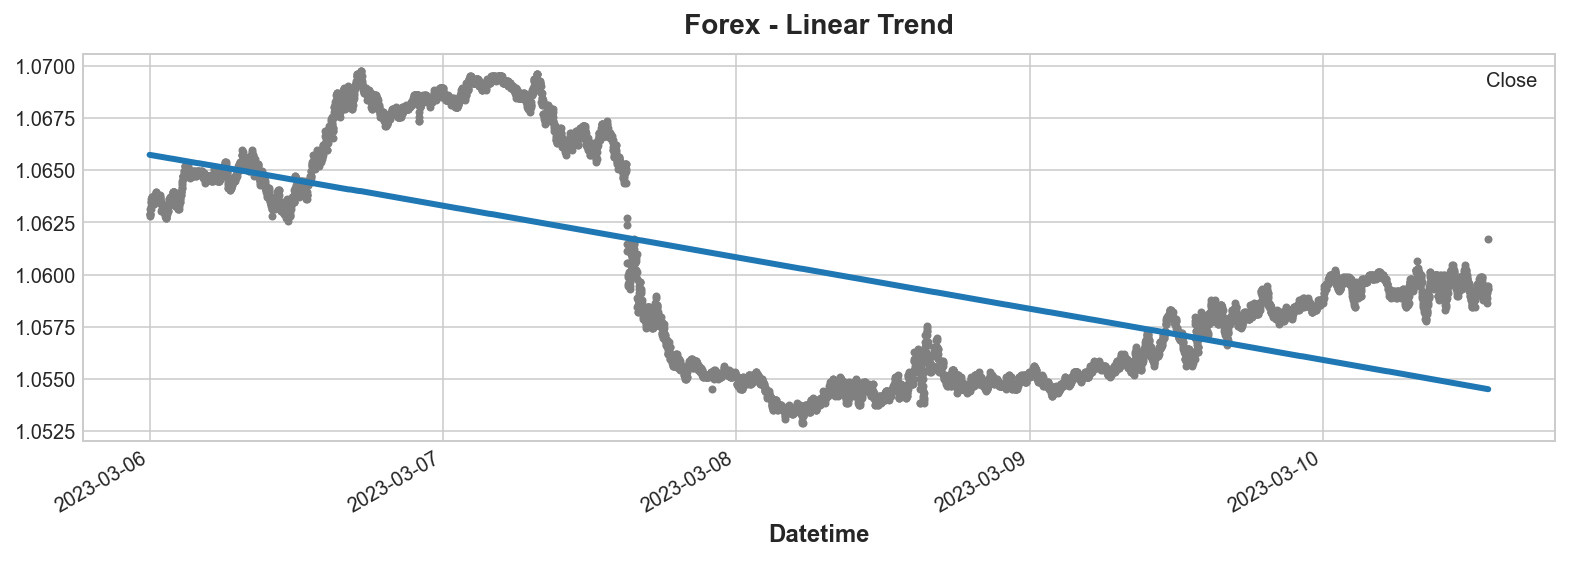

In [62]:
ax = forex.plot(style='.', color='0.5', title='Forex - Linear Trend')

_ = y_pred.plot(ax=ax, linewidth=3, label='Trend')

In [63]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

C:\Users\badbw\anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:147: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Int64Indexes with a unit increment support extending. The index is set will contain the position relative to the data length.
  warnings.warn(


6448    1.054493
6449    1.054491
6450    1.054489
6451    1.054488
6452    1.054486
dtype: float64

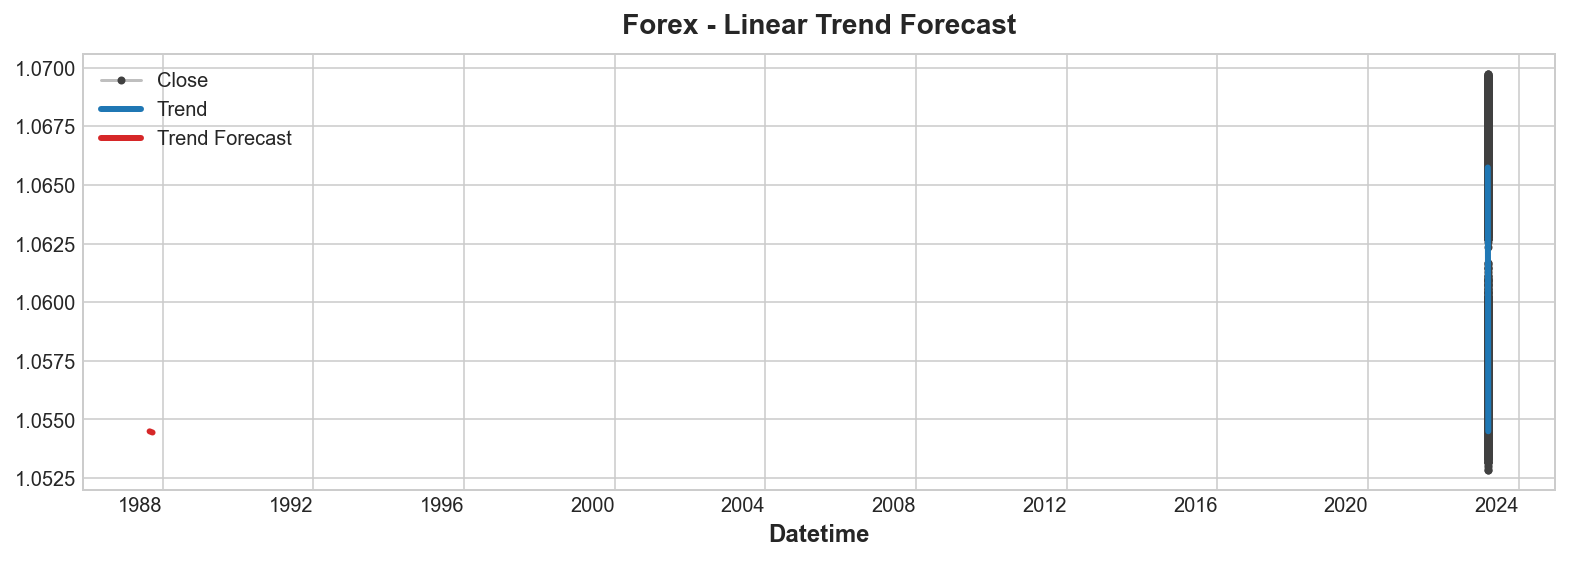

In [64]:
ax = forex["2005-05":].plot(title="Forex - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

## Seasonality

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

